# DNN

## Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

import sys
import os
import warnings

keras = tf.keras

# set style of charts
sns.set(style="darkgrid")
plt.rcParams['figure.figsize'] = [10, 10]

C:\Users\Ananya\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Ananya\anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\Ananya\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" # Also affect subprocesses

In [3]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

def window_dataset(series, window_size, batch_size=128,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [5]:
# Read in data
df = pd.read_csv('./GBPUSD.csv')

# Convert series into datetime type
df.index = pd.to_datetime(df['Date'])

# Save target series
series = df['Close']

#Size of exchange rates
total_size = df.shape[0]
print(total_size)

#Use 70% of data as training, rest 10% to Validation, and 10% to Test model
valid_split_index = int(total_size * 0.8)
test_split_index = int(total_size * 0.1)
x_train = df.iloc[0:valid_split_index].Close
x_valid = df.iloc[valid_split_index:-test_split_index].Close
x_test = df.iloc[-test_split_index:total_size].Close

4852


In [6]:
# Reshape the datsets
x_train_values = x_train.values.reshape(-1, 1)
x_valid_values = x_valid.values.reshape(-1, 1)
x_test_values = x_test.values.reshape(-1, 1)

# Create a Scaler Object
x_train_scaler = MinMaxScaler(feature_range=(0, 1))

# normalize training data
normalized_x_train = x_train_scaler.fit_transform(x_train_values)

# normalize validation data
normalized_x_valid = x_train_scaler.transform(x_valid_values)

# normalize test data
normalized_x_test = x_train_scaler.transform(x_test_values)

# Normalized to training data
forex_normalized_to_traindata = x_train_scaler.transform(series.values.reshape(-1, 1))

#### Find Best Learning Rate

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 20
train_set = window_dataset(normalized_x_train.flatten(), window_size)

model = keras.models.Sequential([
  keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  keras.layers.Dense(10, activation="relu"),
  keras.layers.Dense(1)
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 20))
optimizer = keras.optimizers.Nadam(lr=1e-7)
model.compile(loss="mean_squared_error",
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule], verbose=0)

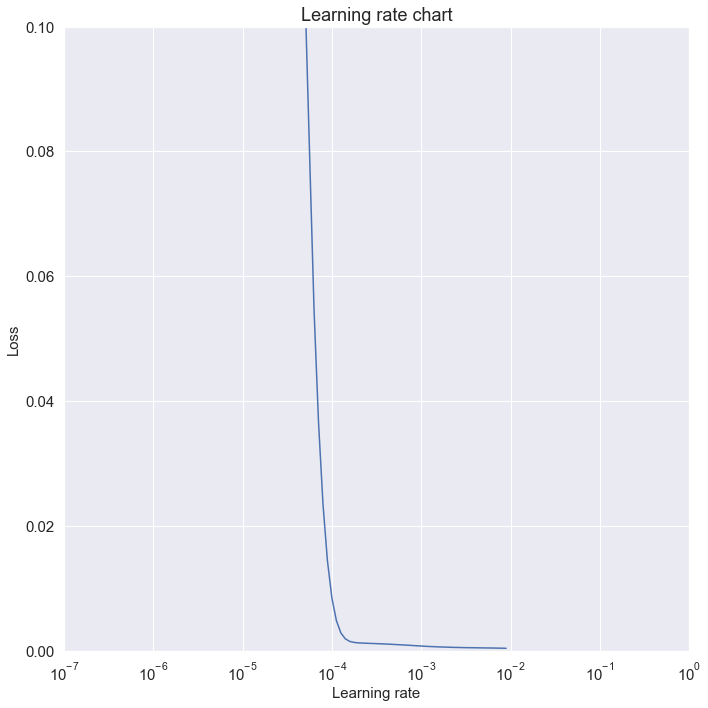

In [8]:
# Plot the learning rate chart
plt.semilogx(history.history["lr"], history.history["loss"])
plt.title('Learning rate chart', fontsize=18)
plt.xlabel('Learning rate', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.axis([1e-7, 1, 0, 0.1])
plt.tight_layout()
plt.show()

#### using grid search to optimize model hyperparameters

In [8]:
# create a list of configs to try
def model_configs():
    config = {}
    # define scope of configs
    n_epochs = [100, 500]
    optimizers = [keras.optimizers.Adam(learning_rate=1e-3), keras.optimizers.Nadam(learning_rate=1e-3), keras.optimizers.SGD(learning_rate=1e-3), keras.optimizers.Adagrad(learning_rate=1e-3)]
    losses = [keras.losses.MeanSquaredError(), keras.losses.MeanAbsoluteError()]
    # Make a dictionary of the grid search parameters
    configs = list()
    for epoch in n_epochs:
        for optim in optimizers:
            for loss in losses:
                param_grids = dict(optimizers = optim, loss = loss, epochs=epoch)    # create configs
                configs.append(param_grids)
    print('Total configs: %d' % len(configs))
    return configs

In [9]:
configs = model_configs()
len(configs)

Total configs: 16


16

#### Create Model

In [ ]:
# Clear back end
keras.backend.clear_session()

# Ensure reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Set Window Size
window_size = 20
train_set = window_dataset(normalized_x_train.flatten(), window_size)
valid_set = window_dataset(normalized_x_valid.flatten(), window_size)

# Build 2 layer model with 10 neurons each and 1 output layer
model = keras.models.Sequential([
  keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  keras.layers.Dense(10, activation="relu"),
  keras.layers.Dense(1)
])

# Set optimizer
optimizer = keras.optimizers.Nadam(lr=1e-3)
model.compile(loss="mean_squared_error",
              optimizer=optimizer,
              metrics=["mae"])

# Set early Stopping
early_stopping = keras.callbacks.EarlyStopping(patience=20)

# create save points for best model
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint", save_best_only=True)

# Fit model
history = model.fit(train_set, epochs=500,
                    validation_data=valid_set,
                    callbacks=[early_stopping, model_checkpoint])

In [10]:
model = keras.models.load_model("my_checkpoint")

In [11]:
dense_forecast = model_forecast(model, forex_normalized_to_traindata.flatten()[-test_split_index - window_size:-1], window_size)[:, 0]

In [12]:
forex_normalized_to_traindata.flatten().shape

(4852,)

In [13]:
# Undo the scaling
dense_forecast = x_train_scaler.inverse_transform(dense_forecast.reshape(-1,1)).flatten()
dense_forecast.shape

(485,)

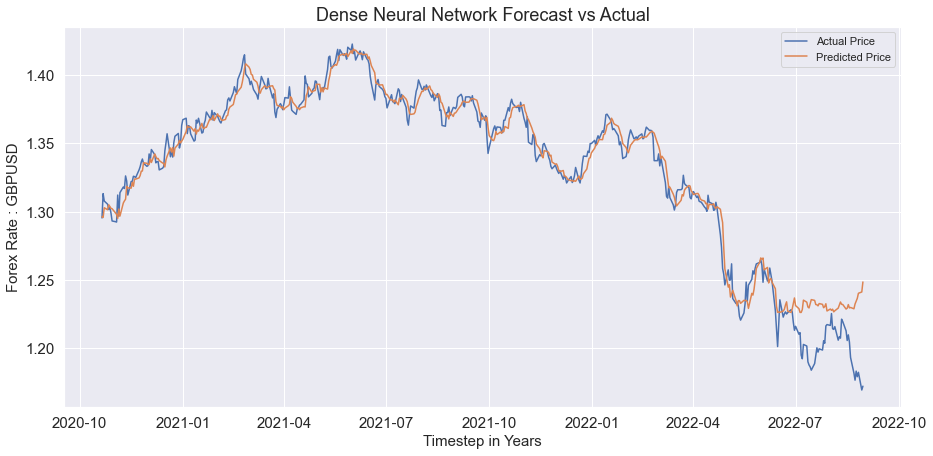

In [14]:
# set style of charts
sns.set(style="darkgrid")

plt.figure(figsize=(15, 7))
plot_series(x_test.index, x_test, label="Actual Price")
plot_series(x_test.index, dense_forecast, label="Predicted Price")
plt.title('Dense Neural Network Forecast vs Actual', fontsize=18)
plt.legend()
plt.ylabel('Forex Rate : GBPUSD', fontsize=15)
plt.xlabel('Timestep in Years', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

#### Dense Model Result

In [17]:
model_scores = pd.read_csv("./Model scores.csv", index_col=0)

# MAE
dense_mae = keras.metrics.mean_absolute_error(x_test, dense_forecast).numpy()

# Using the mean_absolute_percentage_error function
from sklearn.metrics import mean_absolute_percentage_error

# MAPE
dense_mape = mean_absolute_percentage_error(x_test, dense_forecast) * 100

model_scores.loc[len(model_scores.index)] = ["Dense Neural Network", dense_mae, dense_mape]

# view the dataframe of scores
model_scores

,Model,MAE,MAPE in %
0,Naive Model,0.004958,0.374773
1,MA5,0.011715,0.890453
2,MA20,0.024235,1.840606
3,"ARIMA (0,1,0)",0.004958,0.374773
4,"Linear model (MA5, MA20)",0.005484,0.414356
5,Dense Neural Network,0.011224,0.858841
6,LSTM,0.002854,0.211474
7,RNN,0.005412,0.410384
8,CNN Wavenet,0.022571,1.715851
9,Dense Neural Network,0.008336,0.648385


In [18]:
model_scores.to_csv("./Model scores.csv")

In [ ]:
from tqdm.notebook import tqdm, trange

# Clear back end
keras.backend.clear_session()

# Ensure reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Set Window Size
window_size = 20
train_set = window_dataset(normalized_x_train.flatten(), window_size)
valid_set = window_dataset(normalized_x_valid.flatten(), window_size)

x=1
mae_df = pd.DataFrame(columns=["MAE score", "config"])


for config in tqdm(configs, desc="Progress"):
    # Build 2 layer model with 10 neurons each and 1 output layer
    print("Training for config : ", config)
    model = keras.models.Sequential([
      keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
      keras.layers.Dense(10, activation="relu"),
      keras.layers.Dense(1)
    ])

    # Set optimizer
    optimizer = config["optimizers"]
    
    model.compile(loss=config["loss"],
              optimizer=optimizer,
              metrics=["mae"])

    # Set early Stopping
    early_stopping = keras.callbacks.EarlyStopping(patience=20)
    
    config_list = (config["epochs"], config["optimizers"], config["loss"])

    # create save points for best model
    model_checkpoint = keras.callbacks.ModelCheckpoint(
        "my_checkpoint"+str(x), save_best_only=True)
    
    x+=1

    # Fit model
    history = model.fit(train_set, epochs=config["epochs"],
                    validation_data=valid_set,
                    callbacks=[early_stopping, model_checkpoint], verbose=0)
    
    dense_forecast = model_forecast(model, forex_normalized_to_traindata.flatten()[-test_split_index - window_size:-1], window_size)[:, 0]
    # Undo the scaling
    dense_forecast = x_train_scaler.inverse_transform(dense_forecast.reshape(-1,1)).flatten()
    mae_score = keras.metrics.mean_absolute_error(x_test, dense_forecast).numpy()
    
    mae_df.loc[len(mae_df.index)] = [mae_score, config_list]

mae_df.sort_values(by = "MAE score")

In [38]:
mae_df = pd.DataFrame(columns=["MAE score", "config"])
   
for a in range(1, 17):
    config = configs[a-1]
    optim = config["optimizers"].__class__.__name__
    loss = config["loss"].__class__.__name__
    
    config_list = (config["epochs"], optim, loss)
    
    model = keras.models.load_model("my_checkpoint"+str(a))
    dense_forecast = model_forecast(model, forex_normalized_to_traindata.flatten()[-test_split_index - window_size:-1], window_size)[:, 0]
    # Undo the scaling
    dense_forecast = x_train_scaler.inverse_transform(dense_forecast.reshape(-1,1)).flatten()
    mae_score = keras.metrics.mean_absolute_error(x_test, dense_forecast).numpy()
    
    mae_df.loc[len(mae_df.index)] = [mae_score, config_list]

mae_df = mae_df.sort_values(by = "MAE score")
print(mae_df)

    MAE score                             config
11   0.005551    (500, Nadam, MeanAbsoluteError)
10   0.005558     (500, Nadam, MeanSquaredError)
9    0.005675     (500, Adam, MeanAbsoluteError)
8    0.006058      (500, Adam, MeanSquaredError)
0    0.006149      (100, Adam, MeanSquaredError)
3    0.006803    (100, Nadam, MeanAbsoluteError)
1    0.007360     (100, Adam, MeanAbsoluteError)
13   0.008494      (500, SGD, MeanAbsoluteError)
2    0.009287     (100, Nadam, MeanSquaredError)
7    0.010544  (100, Adagrad, MeanAbsoluteError)
5    0.013778      (100, SGD, MeanAbsoluteError)
12   0.017032       (500, SGD, MeanSquaredError)
4    0.042981       (100, SGD, MeanSquaredError)
15   0.051947  (500, Adagrad, MeanAbsoluteError)
6    0.056884   (100, Adagrad, MeanSquaredError)
14   0.074691   (500, Adagrad, MeanSquaredError)


In [39]:
mae_df

,MAE score,config
11,0.005551,"(500, Nadam, MeanAbsoluteError)"
10,0.005558,"(500, Nadam, MeanSquaredError)"
9,0.005675,"(500, Adam, MeanAbsoluteError)"
8,0.006058,"(500, Adam, MeanSquaredError)"
0,0.006149,"(100, Adam, MeanSquaredError)"
3,0.006803,"(100, Nadam, MeanAbsoluteError)"
1,0.007360,"(100, Adam, MeanAbsoluteError)"
13,0.008494,"(500, SGD, MeanAbsoluteError)"
2,0.009287,"(100, Nadam, MeanSquaredError)"
7,0.010544,"(100, Adagrad, MeanAbsoluteError)"


In [40]:
mae_df.to_csv("DNN simulations")